=== Model 0: RNN-based Hawkes Process ===
Intensity (Model 0):
 tensor([[[0.6893, 0.6623, 0.6356, 0.7874],
         [0.6846, 0.6721, 0.6318, 0.7753],
         [0.7307, 0.6989, 0.6385, 0.8020],
         [0.7490, 0.6979, 0.6350, 0.8122],
         [0.7590, 0.6976, 0.6297, 0.8189],
         [0.7646, 0.6970, 0.6248, 0.8234],
         [0.7317, 0.6986, 0.6061, 0.8149],
         [0.7115, 0.6965, 0.6115, 0.7865],
         [0.6906, 0.7016, 0.6367, 0.8066],
         [0.7177, 0.7005, 0.6288, 0.8101]],

        [[0.6989, 0.6187, 0.6631, 0.7849],
         [0.7178, 0.6439, 0.6462, 0.8346],
         [0.7060, 0.6654, 0.6239, 0.8151],
         [0.7214, 0.6480, 0.6540, 0.7869],
         [0.6986, 0.6614, 0.6371, 0.7958],
         [0.7151, 0.6451, 0.6547, 0.7702],
         [0.6925, 0.6600, 0.6391, 0.7871],
         [0.6693, 0.6732, 0.6548, 0.8090],
         [0.7091, 0.6817, 0.6351, 0.8203],
         [0.7294, 0.6921, 0.6249, 0.8247]]], grad_fn=<SoftplusBackward0>)

=== Model 1: Basic Transformer Hawkes ===


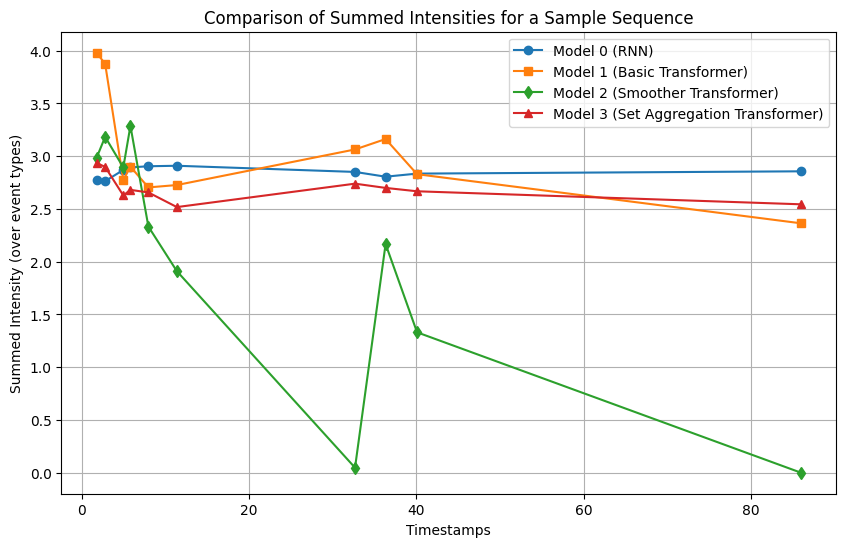

In [1]:
# %% [markdown]
# # Transformer Hawkes Process Variants and a Baseline RNN Model
# 
# This notebook demonstrates:
# 
# - **Model 0:** A typical RNN-based Hawkes process.
# - **Model 1:** Basic Transformer Hawkes Process.
# - **Model 2:** Smoother Transformer Hawkes Process.
# - **Model 3:** Set Aggregation Transformer Hawkes Process.
# 
# We then compare the outputs (intensities) generated by the four models using a plot.

# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

# %%
# Temporal Encoding (used by Transformer models)
class TemporalEncoding(nn.Module):
    def __init__(self, M):
        """
        M: the dimension of the encoding.
        """
        super(TemporalEncoding, self).__init__()
        self.M = M

    def forward(self, t):
        """
        t: a tensor of shape (L,) representing timestamps.
        Returns: tensor of shape (L, M)
        """
        L = t.size(0)
        pe = torch.zeros(L, self.M, device=t.device)
        position = t.unsqueeze(1)  # (L, 1)
        div_term = torch.exp(torch.arange(0, self.M, 2, dtype=torch.float32, device=t.device) *
                             (-math.log(10000.0) / self.M))
        pe[:, 0::2] = torch.cos(position * div_term)
        pe[:, 1::2] = torch.sin(position * div_term)
        return pe

# %%
# Event Embedding (used by both Transformer and RNN models)
class EventEmbedding(nn.Module):
    def __init__(self, num_event_types, M):
        """
        num_event_types: number of discrete event types.
        M: embedding dimension.
        """
        super(EventEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_event_types, M)
    
    def forward(self, event_types):
        """
        event_types: tensor of shape (L,) of integers.
        Returns: tensor of shape (L, M)
        """
        return self.embedding(event_types)

# %%
# Model 0: RNN-based Hawkes Process
# Here, we use an LSTM that takes as input the concatenation of the event embedding and a normalized timestamp.
class RNNHawkesProcess(nn.Module):
    def __init__(self, num_event_types, M, hidden_dim, num_layers=1):
        """
        num_event_types: number of discrete event types.
        M: embedding dimension for event types.
        hidden_dim: hidden dimension of the LSTM.
        num_layers: number of LSTM layers.
        """
        super(RNNHawkesProcess, self).__init__()
        self.M = M
        self.event_embed = EventEmbedding(num_event_types, M)
        # We include a 1-dim time feature. (We normalize time by dividing by 100.)
        self.input_dim = M + 1  
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True)
        self.intensity_linear = nn.Linear(hidden_dim, num_event_types)
        self.softplus = nn.Softplus()

    def forward(self, event_types, times):
        """
        event_types: tensor of shape (B, L) of integers.
        times: tensor of shape (B, L) of timestamps.
        Returns:
          intensity: (B, L, num_event_types)
          H: hidden states from the LSTM (B, L, hidden_dim)
        """
        B, L = event_types.shape
        # Get event embeddings: (B, L, M)
        emb = self.event_embed(event_types)
        # Normalize times (e.g., divide by 100) and reshape to (B, L, 1)
        times_norm = (times / 100.0).unsqueeze(-1)
        # Concatenate embedding and time feature: (B, L, M+1)
        X = torch.cat([emb, times_norm], dim=-1)
        # Process sequence with LSTM.
        H, _ = self.lstm(X)  # H shape: (B, L, hidden_dim)
        # Compute intensity.
        intensity_raw = self.intensity_linear(H)  # (B, L, num_event_types)
        intensity = self.softplus(intensity_raw)
        return intensity, H

# %%
# Model 1: Basic Transformer Hawkes Process
class BasicTransformerHawkesProcess(nn.Module):
    def __init__(self, num_event_types, M, num_heads, d_ff):
        super(BasicTransformerHawkesProcess, self).__init__()
        self.M = M
        self.event_embed = EventEmbedding(num_event_types, M)
        self.temporal_encoding = TemporalEncoding(M)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=M, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(M, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, M)
        )
        self.intensity_linear = nn.Linear(M, num_event_types)
        self.softplus = nn.Softplus()

    def forward(self, event_types, times, attn_mask=None):
        B, L = event_types.shape
        emb_events = self.event_embed(event_types)  # (B, L, M)
        pe = torch.stack([self.temporal_encoding(times[b]) for b in range(B)], dim=0)  # (B, L, M)
        X = emb_events + pe  # (B, L, M)
        attn_output, attn_weights = self.multihead_attn(X, X, X, key_padding_mask=attn_mask)
        X2 = X + attn_output  # Residual connection.
        ffn_output = self.ffn(X2)
        H = X2 + ffn_output  # Final hidden representation.
        intensity_raw = self.intensity_linear(H)  # (B, L, num_event_types)
        intensity = self.softplus(intensity_raw)
        return intensity, H, attn_weights

# %%
# Model 2: Smoother Transformer Hawkes Process
class SmootherTransformerHawkesProcess(nn.Module):
    def __init__(self, num_event_types, M, num_heads, d_ff):
        super(SmootherTransformerHawkesProcess, self).__init__()
        self.M = M
        self.event_embed = EventEmbedding(num_event_types, M)
        self.temporal_encoding = TemporalEncoding(M)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=M, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(M, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, M)
        )
        self.intensity_linear = nn.Linear(M, num_event_types)
        # Nonparametric smoother: an MLP on the elapsed time.
        self.smoother = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        self.softplus = nn.Softplus()

    def forward(self, event_types, times, attn_mask=None):
        B, L = event_types.shape
        emb_events = self.event_embed(event_types)  # (B, L, M)
        pe = torch.stack([self.temporal_encoding(times[b]) for b in range(B)], dim=0)  # (B, L, M)
        X = emb_events + pe  # (B, L, M)
        attn_output, attn_weights = self.multihead_attn(X, X, X, key_padding_mask=attn_mask)
        X2 = X + attn_output
        ffn_output = self.ffn(X2)
        H = X2 + ffn_output
        intensity_raw = self.intensity_linear(H)
        # Compute elapsed time between events (set first elapsed to 0).
        elapsed = torch.zeros_like(times)
        elapsed[:, 1:] = times[:, 1:] - times[:, :-1]
        elapsed_unsq = elapsed.unsqueeze(-1)
        s = self.smoother(elapsed_unsq)  # (B, L, 1)
        intensity_enhanced = intensity_raw + s  # Add smoother output.
        intensity = self.softplus(intensity_enhanced)
        return intensity, H, attn_weights

# %%
# Model 3: Set Aggregation Transformer Hawkes Process
class SetAggregationTransformerHawkesProcess(nn.Module):
    def __init__(self, num_event_types, M, num_heads, d_ff):
        super(SetAggregationTransformerHawkesProcess, self).__init__()
        self.M = M
        self.event_embed = EventEmbedding(num_event_types, M)
        self.temporal_encoding = TemporalEncoding(M)
        # Concatenate instead of summing, then project back to M.
        self.proj = nn.Linear(2 * M, M)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=M, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(M, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, M)
        )
        self.global_context = nn.Linear(M, M)
        self.intensity_linear = nn.Linear(M, num_event_types)
        self.softplus = nn.Softplus()
        
    def forward(self, event_types, times, attn_mask=None):
        B, L = event_types.shape
        emb_events = self.event_embed(event_types)  # (B, L, M)
        pe = torch.stack([self.temporal_encoding(times[b]) for b in range(B)], dim=0)  # (B, L, M)
        X_cat = torch.cat([emb_events, pe], dim=-1)  # (B, L, 2*M)
        X = self.proj(X_cat)  # (B, L, M)
        attn_output, attn_weights = self.multihead_attn(X, X, X, key_padding_mask=attn_mask)
        X2 = X + attn_output
        ffn_output = self.ffn(X2)
        H = X2 + ffn_output  # (B, L, M)
        # Global context via mean pooling.
        global_vec = H.mean(dim=1)  # (B, M)
        global_context = self.global_context(global_vec)  # (B, M)
        global_context_expanded = global_context.unsqueeze(1).expand(-1, L, -1)
        H_combined = H + global_context_expanded
        intensity_raw = self.intensity_linear(H_combined)
        intensity = self.softplus(intensity_raw)
        return intensity, H, attn_weights

# %%
# Generate sample data (same for all models)
def generate_sample_data(batch_size, seq_length, num_event_types):
    # Random event types in {0, ..., num_event_types-1}
    event_types = torch.randint(0, num_event_types, (batch_size, seq_length))
    # Generate sorted random timestamps (simulate increasing times)
    times = torch.zeros(batch_size, seq_length)
    for b in range(batch_size):
        times[b] = torch.sort(torch.rand(seq_length) * 100)[0]
    return event_types, times

# %%
# Set parameters.
num_event_types = 4   # e.g., event types: 0, 1, 2, 3
M = 32                # Embedding/encoding dimension
num_heads = 4
d_ff = 64             # Feed-forward dimension
batch_size = 2
seq_length = 10

# Generate data.
event_types, times = generate_sample_data(batch_size, seq_length, num_event_types)

# %%
# Instantiate and run Model 0 (RNN-based Hawkes)
hidden_dim = 32
model0 = RNNHawkesProcess(num_event_types, M, hidden_dim)
intensity0, H0 = model0(event_types, times)
print("=== Model 0: RNN-based Hawkes Process ===")
print("Intensity (Model 0):\n", intensity0)

# %%
# Instantiate and run Model 1 (Basic Transformer Hawkes)
model1 = BasicTransformerHawkesProcess(num_event_types, M, num_heads, d_ff)
intensity1, H1, attn_weights1 = model1(event_types, times)
print("\n=== Model 1: Basic Transformer Hawkes ===")
print("Intensity (Model 1):\n", intensity1)

# %%
# Instantiate and run Model 2 (Smoother Transformer Hawkes)
model2 = SmootherTransformerHawkesProcess(num_event_types, M, num_heads, d_ff)
intensity2, H2, attn_weights2 = model2(event_types, times)
print("\n=== Model 2: Smoother Transformer Hawkes ===")
print("Intensity (Model 2):\n", intensity2)

# %%
# Instantiate and run Model 3 (Set Aggregation Transformer Hawkes)
model3 = SetAggregationTransformerHawkesProcess(num_event_types, M, num_heads, d_ff)
intensity3, H3, attn_weights3 = model3(event_types, times)
print("\n=== Model 3: Set Aggregation Transformer Hawkes ===")
print("Intensity (Model 3):\n", intensity3)

# %%
# Comparison: For ease of comparison, we compute a summary measure of the intensity.
# Here, we sum the intensity over event types for each event.
def summarize_intensity(intensity):
    # intensity: (B, L, num_event_types)
    # Summing over event types gives a (B, L) tensor.
    return intensity.sum(dim=-1).detach().cpu().numpy()

int0 = summarize_intensity(intensity0)
int1 = summarize_intensity(intensity1)
int2 = summarize_intensity(intensity2)
int3 = summarize_intensity(intensity3)

# For visualization, we pick the first sample in the batch.
times_sample = times[0].detach().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(times_sample, int0[0], 'o-', label='Model 0 (RNN)')
plt.plot(times_sample, int1[0], 's-', label='Model 1 (Basic Transformer)')
plt.plot(times_sample, int2[0], 'd-', label='Model 2 (Smoother Transformer)')
plt.plot(times_sample, int3[0], '^-', label='Model 3 (Set Aggregation Transformer)')
plt.xlabel('Timestamps')
plt.ylabel('Summed Intensity (over event types)')
plt.title('Comparison of Summed Intensities for a Sample Sequence')
plt.legend()
plt.grid(True)
plt.show()
